In [24]:
from typing import TypedDict, Optional, List, Callable, Dict, Any, Literal
from typing_extensions import Annotated
import os
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from youtube_transcript_api import YouTubeTranscriptApi
from langgraph.graph import StateGraph, add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.graph import START, END

In [25]:
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [36]:
class BlogGenState(TypedDict):
    yt_url: Optional[str]
    transcript: Optional[str]
    blog_title: Optional[str]
    blog_content: Optional[str]
    regenerate_status: Optional[str]
    message: Annotated[list[AnyMessage], add_messages]

In [42]:
class Agents:
    def __init__(self):
        self.llm = ChatGroq(model="qwen-2.5-32b")
    def generate_blog(self, state: BlogGenState) -> BlogGenState:
        """
        Generates a title and content for the blog based on the transcript.
        
        Args:
            state: The current state of the workflow
            
        Returns:
            Updated state with blog title and content
        """
        transcript = state.get("transcript")
        if transcript is None:
            video_id = state["yt_url"].split("v=")[-1].split("&")[0]
            transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
            full_transcript = " ".join([entry['text'] for entry in transcript_list])
            state["transcript"] = full_transcript
        regen_status = state.get("regenerate_status")
        if regen_status == "yes":
            title_regenerate_prompt = [
                SystemMessage(content="The user has chosen to regenerate the blog title. Please provide a new title for the blog post based on the transcript. PREVIOUS INSTRUCTIONS: You are an expert in generating titles for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE TITLES FOR THE BLOG. NO EXPLANATION IS REQUIRED."),
                HumanMessage(content=f"Generate a good blog title for a video with the following transcript: {state['transcript']}")
            ]
            content_regenerate_prompt = [
                SystemMessage(content="The user has chosen to regenerate the blog content. Please provide new content for the blog post based on the transcript. PREVIOUS INSTRUCTIONS: You are an expert in generating content for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE CONTENT FOR THE BLOG. THE TITLE IS ALREADY PROVIDED. Output format: Simply output the content in markdown format with appropriate headings, paragraphs, and formatting."),
                HumanMessage(content=f"Generate blog content for the title '{state['blog_title']}' based on the following transcript: {state['transcript']}")
            ]
            regenerated_title = self.llm.invoke(title_regenerate_prompt).content.strip()
            regenerated_content = self.llm.invoke(content_regenerate_prompt).content.strip()

            return {
                "blog_title": regenerated_title,
                "blog_content": regenerated_content,
                "message": state["message"] + [
                    SystemMessage(content=f"Blog title and content regenerated on the users request.")
                ]
            }

        title_prompt = [
            SystemMessage(content="You are an expert in generating titles for BLOG posts based on the transcripts of YouTube videos. IMPORTANT: YOU SIMPLY ONLY CREATE TITLES FOR THE BLOG. NO EXPLANATION IS REQUIRED."),
            HumanMessage(content=f"Generate a good blog title for a video with the following transcript: {state['transcript']}")
        ]
        blog_title = self.llm.invoke(title_prompt).content.strip()

        content_prompt = [
            SystemMessage(content="""You are an expert in generating content for BLOG posts based on the transcripts of YouTube videos. 
            IMPORTANT: YOU SIMPLY ONLY CREATE CONTENT FOR THE BLOG. THE TITLE IS ALREADY PROVIDED. 
            Output format: Simply output the content in markdown format with appropriate headings, paragraphs, and formatting."""),
            HumanMessage(content=f"Generate blog content for the title '{blog_title}' based on the following transcript: {state['transcript']}")
        ]
        blog_content = self.llm.invoke(content_prompt).content.strip()

        return {
            "blog_title": blog_title,
            "blog_content": blog_content,
            "message": state["message"] + [
                SystemMessage(content="Transcript fetched successfully."),
                SystemMessage(content=f"Blog title generated: {blog_title}"),
                SystemMessage(content="Blog content generated successfully.")
            ]
        }
    def human_feedback(self, state: BlogGenState) -> BlogGenState:
        """Just an empty to update the feedback param"""
        return state

In [43]:
class BlogGenGraph:
    def __init__(self):
        self.agents = Agents()
    def regenerate_condition_or_not(self, state: BlogGenState) -> Literal["regenerate","end"]:
        if state["regenerate_status"] == "yes":
            return "regenerate"
        else:    
            return "end" 
    def create_graph(self):
        graph_builder = StateGraph(BlogGenState)
        graph_builder.add_node("generate_blog_with_title",self.agents.generate_blog)
        graph_builder.add_node("human_feedback",self.agents.human_feedback)
        graph_builder.add_edge("generate_blog_with_title","human_feedback")
        graph_builder.add_conditional_edges("human_feedback",self.regenerate_condition_or_not, {"regenerate": "generate_blog_with_title", "end": END})

        graph_builder.set_entry_point("generate_blog_with_title")

        memory = MemorySaver()
        graph = graph_builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])
        return graph

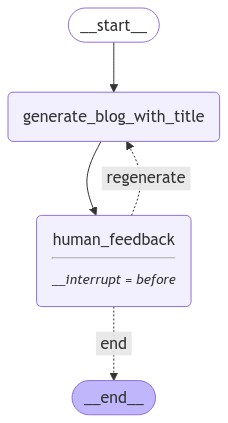

In [53]:
graph = BlogGenGraph().create_graph()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [60]:
youtubelink = "https://www.youtube.com/watch?v=SmyPTnlqhlk"
thread = {"configurable": {"thread_id": "1"}}

In [ ]:
for event in graph.stream({"yt_url": youtubelink},thread, stream_mode="values"):
    content = event.get("blog_content")
    print(content)

# 10 Mind-Boggling Algorithms That Changed the World: From Quantum Computing to Video Game Maps

Algorithms are the backbone of modern technology, allowing machines to solve complex problems and process vast amounts of data. In this blog post, we will explore 10 of the most fascinating algorithms that have revolutionized various fields, from healthcare to video games.

## 1. Marching Cubes: Visualizing Medical Data

In 1987, two programmers at General Electric invented the Marching Cubes algorithm to visualize medical data. This algorithm takes a 3D scalar field (like MRI data) and creates a 3D mesh, enabling doctors to better understand and treat medical conditions. It works by iterating through each point in the 3D space, examining its neighboring points, and using pre-calculated arrays to construct a mesh that accurately represents the data.

## 2. Wave Function Collapse: Procedural Content Generation

Wave Function Collapse takes inspiration from quantum mechanics, specifically the

In [47]:
graph.get_state(thread).next

('human_feedback',)

In [48]:
graph.update_state(thread, {"regenerate_status": "yes"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff5e70-ce49-6053-800c-207bce00e5fa'}}

In [49]:
for event in graph.stream(None,thread, stream_mode="values"):
    print(event)

{'yt_url': 'https://www.youtube.com/watch?v=SmyPTnlqhlk', 'blog_title': '10 Mind-Bending Algorithms That Changed the World: From Quantum Computing to Video Game Maps', 'blog_content': "# 10 Mind-Bending Algorithms That Changed the World: From Quantum Computing to Video Game Maps\n\n## Introduction to Algorithms\n\nHave you ever woken up in the middle of the night, panicking about how to extract a polygonal mesh from a three-dimensional discrete scalar field? Probably not. But in 1987, two programmers at General Electric did just that. They created and patented the marching cubes algorithm, which is used extensively in medical imaging, allowing doctors to visualize data from CT and MRI scans. When you instruct a machine to solve a problem with code, you're creating an algorithm—a procedure that rearranges ones and zeros to solve a problem. While many algorithms might end up in the dumpster, some are fast, beautiful, and so weird they're indistinguishable from magic. \n\n## Wave Function

In [50]:
graph.get_state(thread).next

('human_feedback',)

In [51]:
graph.update_state(thread, {"regenerate_status": "no"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff5e71-a2a9-6fc8-800e-8bcfa8304bb6'}}

In [52]:
for event in graph.stream(None,thread, stream_mode="values"):
    print(event)

{'yt_url': 'https://www.youtube.com/watch?v=SmyPTnlqhlk', 'blog_title': '10 Mind-Boggling Algorithms That Rule the Digital World', 'blog_content': '# 10 Mind-Bending Algorithms That Changed the World: From Quantum Computing to Video Game Maps\n\nAlgorithms are the backbone of modern technology, making it possible to solve complex problems and create innovative solutions. From medical imaging to video game design, here are 10 mind-bending algorithms that have changed the world.\n\n## Wave Function Collapse\n\nWave Function Collapse is a fascinating algorithm that takes inspiration from quantum mechanics. It\'s used in procedural content generation, particularly in creating endless maps for video games. The algorithm starts with an initial map, which can be seen as a superposition of all possibilities. As the game progresses, the map "collapses" into a more defined form, ensuring consistency and coherence. This process is similar to the concept of wave function collapse in quantum physic